# Income Prediction (Census Bureau Dataset)

This notebook predicts whether a person’s income is **<= 50K  or > 50K** using the Census Bureau dataset.


In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.base import clone
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    cross_val_score,
    RandomizedSearchCV,
)

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    precision_score,
    recall_score,
    f1_score,
    make_scorer,
)

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


## 1) Data loading

The Data is set up in the census-bureau.data file and the header values are kept in census-bureau.columns. This is combined into a csv file for reuse and robust storage 


In [2]:
# -----------------------------
# File paths (edit if needed)
# -----------------------------
data_file = "./census-bureau.data"
columns_file = "./census-bureau.columns"
csv_path = "./census-bureau.csv"

# -----------------------------
# Read column names
# -----------------------------
with open(columns_file, "r") as f:
    columns = [line.strip() for line in f if line.strip()]

print("Number of columns found:", len(columns))
print("First few columns:", columns[:10])

# -----------------------------
# Load raw rows, split by commas
# -----------------------------
rows = []
with open(data_file, "r") as f:
    for line in f:
        row = [x.strip() for x in line.strip().split(",")]
        if len(row) == len(columns):
            rows.append(row)

df = pd.DataFrame(rows, columns=columns)
print("Loaded shape:", df.shape)

# Save CSV (optional but handy)
df.to_csv(csv_path, index=False)
print("Saved:", csv_path)
df.head()


Number of columns found: 42
First few columns: ['age', 'class of worker', 'detailed industry recode', 'detailed occupation recode', 'education', 'wage per hour', 'enroll in edu inst last wk', 'marital stat', 'major industry code', 'major occupation code']
Loaded shape: (199523, 42)
Saved: ./census-bureau.csv


,age,class of worker,detailed industry recode,detailed occupation recode,education,wage per hour,enroll in edu inst last wk,marital stat,major industry code,major occupation code,...,country of birth father,country of birth mother,country of birth self,citizenship,own business or self employed,fill inc questionnaire for veteran's admin,veterans benefits,weeks worked in year,year,label
0,73,Not in universe,0,0,High school graduate,0,Not in universe,Widowed,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,- 50000.
1,58,Self-employed-not incorporated,4,34,Some college but no degree,0,Not in universe,Divorced,Construction,Precision production craft & repair,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,- 50000.
2,18,Not in universe,0,0,10th grade,0,High school,Never married,Not in universe or children,Not in universe,...,Vietnam,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,Not in universe,2,0,95,- 50000.
3,9,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.
4,10,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.


## 2) Exploratory Data Analysis
We take a closer look at the data and see various relationships clean up missing data and reduce the feature space if possible without compromising on final model performance 

In [3]:
# Basic overview
display(df.head())
print("Shape:", df.shape)
print("\nDtypes (currently all strings):")
display(df.dtypes.value_counts())


,age,class of worker,detailed industry recode,detailed occupation recode,education,wage per hour,enroll in edu inst last wk,marital stat,major industry code,major occupation code,...,country of birth father,country of birth mother,country of birth self,citizenship,own business or self employed,fill inc questionnaire for veteran's admin,veterans benefits,weeks worked in year,year,label
0,73,Not in universe,0,0,High school graduate,0,Not in universe,Widowed,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,- 50000.
1,58,Self-employed-not incorporated,4,34,Some college but no degree,0,Not in universe,Divorced,Construction,Precision production craft & repair,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,- 50000.
2,18,Not in universe,0,0,10th grade,0,High school,Never married,Not in universe or children,Not in universe,...,Vietnam,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,Not in universe,2,0,95,- 50000.
3,9,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.
4,10,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.


Shape: (199523, 42)

Dtypes (currently all strings):


object    42
Name: count, dtype: int64

### 2.2 Income distribution (<=50K vs >50K)

We see How the income distribution data looks like within our dataset


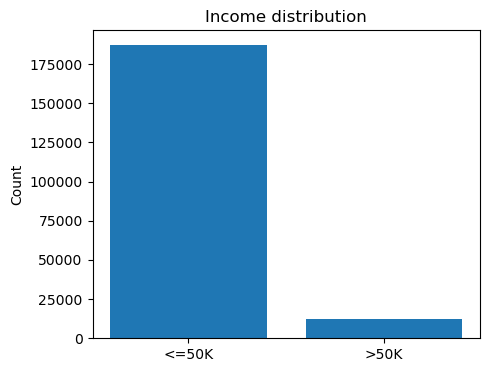

income_binary
0    187141
1     12382
Name: count, dtype: int64

In [10]:
age_col = "age"
sex_col = "sex"
race_col = "race"
marital_col = "marital stat"
label_col = "label"
assert label_col in df.columns, f"Expected label column '{label_col}' not found."

def to_binary_income(x: str) -> int:
    # Common patterns in this dataset include '- 50000.' and '50000+.'
    x = str(x).strip()
    return 1 if ("50000+" in x or ">50K" in x or "> 50K" in x) else 0

df["income_binary"] = df[label_col].apply(to_binary_income)

counts = df["income_binary"].value_counts().sort_index()
labels = ["<=50K", ">50K"]

plt.figure(figsize=(5,4))
plt.bar(labels, counts.values)
plt.title("Income distribution")
plt.ylabel("Count")
plt.show()

counts


### 2.3 Distributions within Income brackets

We see How the age, gender, race and marital status  distribution looks like within our dataset


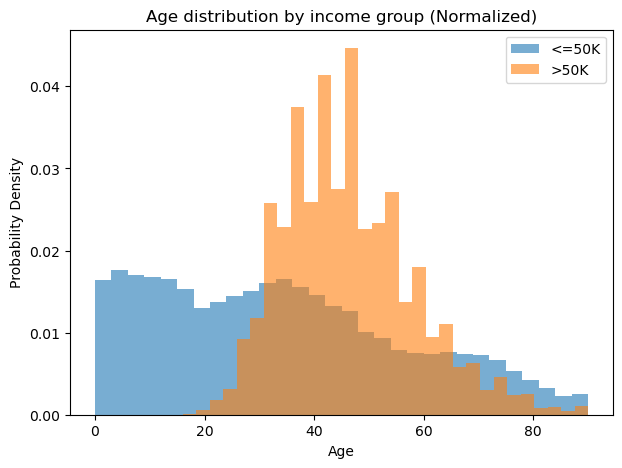

In [11]:
if age_col is None:
    print("No age column detected; skipping plot.")
else:
    age_num = pd.to_numeric(df[age_col], errors="coerce")
    
    plt.figure(figsize=(7,5))
    
    plt.hist(
        age_num[df["income_binary"]==0].dropna(),
        bins=30,
        alpha=0.6,
        density=True,   # <-- normalization
        label="<=50K"
    )
    
    plt.hist(
        age_num[df["income_binary"]==1].dropna(),
        bins=30,
        alpha=0.6,
        density=True,   # <-- normalization
        label=">50K"
    )
    
    plt.title("Age distribution by income group (Normalized)")
    plt.xlabel("Age")
    plt.ylabel("Probability Density")
    plt.legend()
    plt.show()


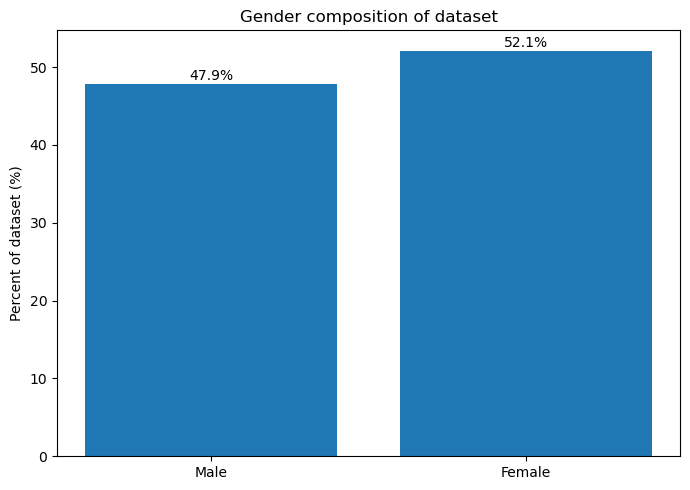

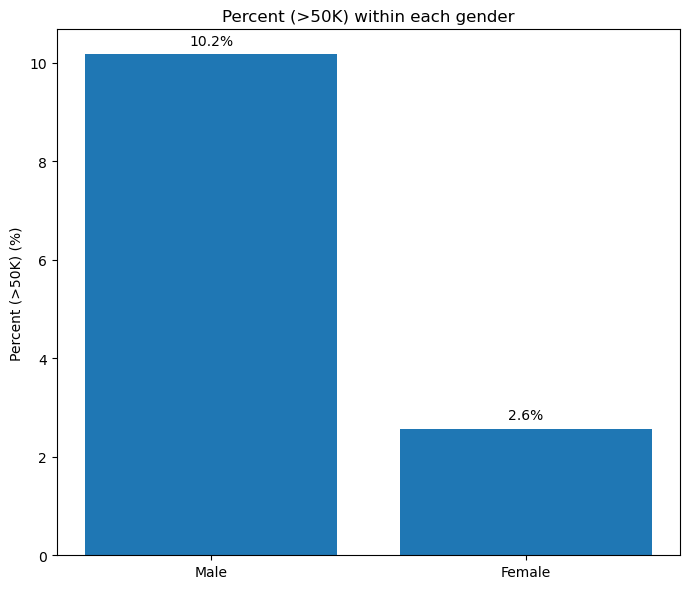

In [19]:

if sex_col is None:
    print("No sex/gender column detected; skipping plot.")
else:
    sex = df[sex_col].astype(str).str.strip().str.lower()

    
    sex_std = sex.replace({
        "m": "Male", "male": "Male",
        "f": "Female", "female": "Female"
    })

    # Keep only Male/Female (drop unknowns if any)
    mask = sex_std.isin(["Male", "Female"])
    df_g = df.loc[mask].copy()
    df_g["sex_std"] = sex_std[mask]

    
    gender_pct = df_g["sex_std"].value_counts(normalize=True).mul(100).reindex(["Male", "Female"])

    plt.figure(figsize=(7,5))
    plt.bar(gender_pct.index, gender_pct.values)
    plt.title("Gender composition of dataset")
    plt.ylabel("Percent of dataset (%)")
    for i, v in enumerate(gender_pct.values):
        plt.text(i, v + 0.5, f"{v:.1f}%", ha="center")
    plt.tight_layout()
    plt.show()

    
    rich_pct = (
        df_g.groupby("sex_std")["income_binary"]
        .mean()
        .mul(100)
        .reindex(["Male", "Female"])
    )

    plt.figure(figsize=(7,6))
    plt.bar(rich_pct.index, rich_pct.values)
    plt.title("Percent (>50K) within each gender")
    plt.ylabel("Percent (>50K) (%)")
    for i, v in enumerate(rich_pct.values):
        plt.text(i, v + 0.2, f"{v:.1f}%", ha="center")
    plt.tight_layout()
    plt.show()

,<=50K,>50K
race,,
White,156093,11272
Black,19875,540
Asian or Pacific Islander,5405,430
Other,3566,91
Amer Indian Aleut or Eskimo,2202,49


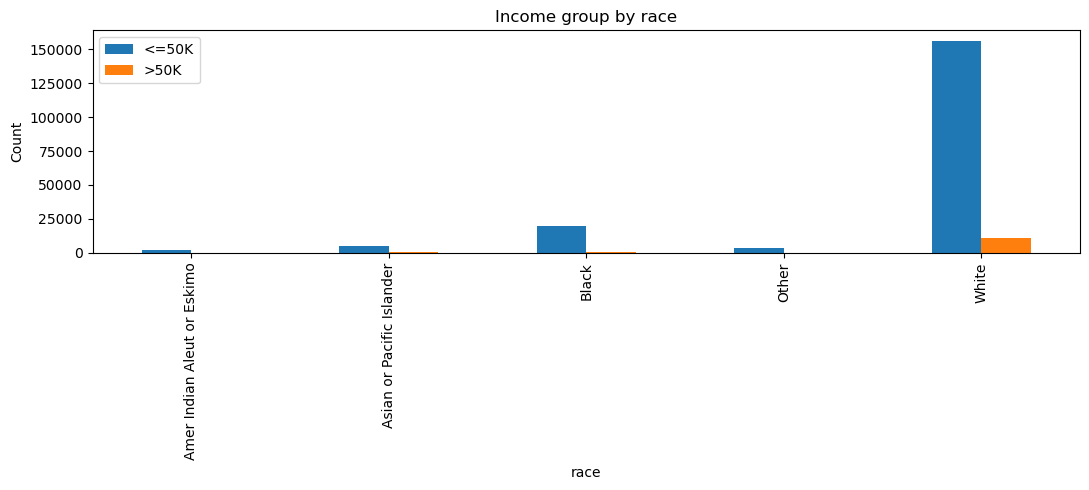

,<=50K,>50K
marital stat,,
Married-civilian spouse present,74622,9600
Never married,85368,1117
Divorced,11644,1066
Widowed,10133,330
Separated,3302,158
Married-spouse absent,1422,96
Married-A F spouse present,650,15


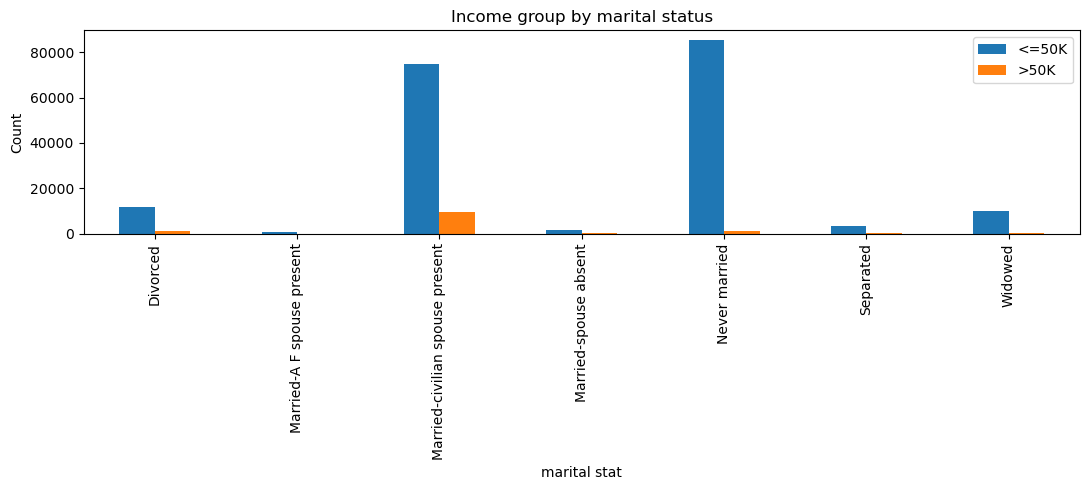

In [20]:
for col, title in [(race_col, "race"), (marital_col, "marital status")]:
    if col is None:
        print(f"No {title} column detected; skipping.")
        continue

    tab = pd.crosstab(df[col], df["income_binary"])
    tab.columns = ["<=50K", ">50K"]

    # Show top groups by >50K count for readability
    display(tab.sort_values(">50K", ascending=False).head(20))

    tab.plot(kind="bar", figsize=(11,5))
    plt.title(f"Income group by {title}")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()


## 3) Cleaning + feature/target setup

We check for missing data and convert `?` → missing (`NaN`), strip whitespace, and define `X` and `y`.

In [22]:
missing_counts = (df == "?").sum()
missing_counts = missing_counts[missing_counts > 0].sort_values(ascending=False)

missing_percent = (missing_counts / len(df)) * 100


missing_summary = pd.DataFrame({
    "missing_?": missing_counts,
    "percent_%": missing_percent.round(2)
})

print("Columns with '?' missing values:")
display(missing_summary)

total_missing = int((df == "?").sum().sum())
total_percent = (total_missing / (df.shape[0] * df.shape[1])) * 100

print(f"\nTotal '?' in dataset: {total_missing}")
print(f"Overall percentage of missing cells: {total_percent:.2f}%")


Columns with '?' missing values:


,missing_?,percent_%
migration code-change in msa,99696,49.97
migration code-change in reg,99696,49.97
migration code-move within reg,99696,49.97
migration prev res in sunbelt,99696,49.97
country of birth father,6713,3.36
country of birth mother,6119,3.07
country of birth self,3393,1.70
state of previous residence,708,0.35



Total '?' in dataset: 415717
Overall percentage of missing cells: 4.85%


We have columns with almost 50% of data missing. Including this data in our training even setting them as unknowns will add noise to our data and bias our models. So eliminating them is the best option

In [23]:
missing_percent = ((df == "?").sum() / len(df)) * 100
threshold = 40
cols_to_drop = missing_percent[missing_percent > threshold].index.tolist()

print("Dropping columns (>40% missing):")
print(cols_to_drop)

df = df.drop(columns=cols_to_drop)
print("\nRemaining shape:", df.shape)


Dropping columns (>40% missing):
['migration code-change in msa', 'migration code-change in reg', 'migration code-move within reg', 'migration prev res in sunbelt']

Remaining shape: (199523, 39)


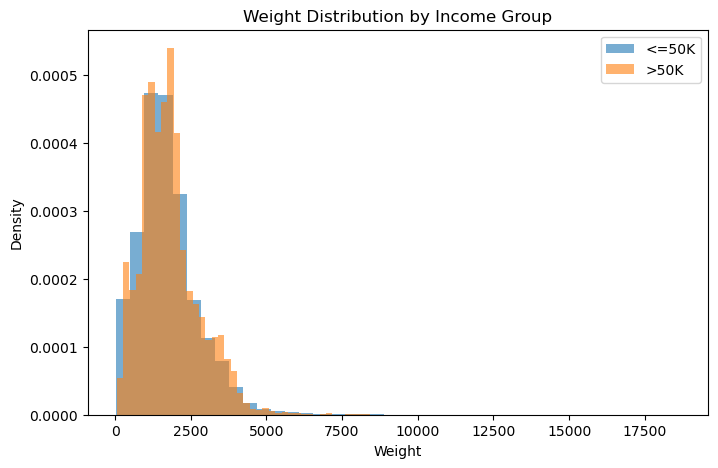

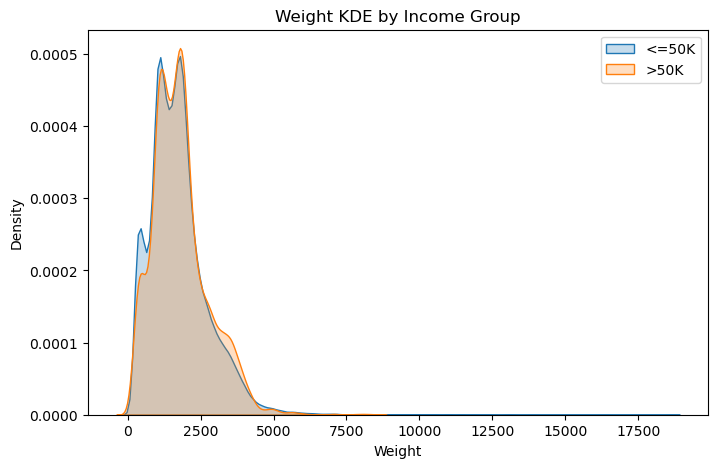

In [24]:
weight_col = "weight"  

df[weight_col] = pd.to_numeric(df[weight_col], errors="coerce")

low_income = df[df["income_binary"] == 0][weight_col].dropna()
high_income = df[df["income_binary"] == 1][weight_col].dropna()

plt.figure(figsize=(8,5))

plt.hist(low_income, bins=40, alpha=0.6, density=True, label="<=50K")
plt.hist(high_income, bins=40, alpha=0.6, density=True, label=">50K")

plt.xlabel("Weight")
plt.ylabel("Density")
plt.title("Weight Distribution by Income Group")
plt.legend()
plt.show()
import seaborn as sns

plt.figure(figsize=(8,5))
sns.kdeplot(low_income, label="<=50K", fill=True)
sns.kdeplot(high_income, label=">50K", fill=True)

plt.title("Weight KDE by Income Group")
plt.xlabel("Weight")
plt.legend()
plt.show()


We see that the weight distribution is the same for both income brackets. So we have two options 1) drop the weights entirely 2) input as sample weights in training. Option 2 is prefered here since it makes more sense physically

Now we proceed to clan up the missing data and replace "?" with nan prepare the data for training 

In [27]:
# Replace '?' with actual missing values
df = df.replace("?", np.nan)

# Strip whitespace across object columns
for c in df.columns:
    if df[c].dtype == "object":
        df[c] = df[c].astype(str).str.strip()

# Recreate target after cleanup
df["income_binary"] = df[label_col].apply(to_binary_income)

weight_col = "weight"
print(f"Using '{weight_col}' as sample-weight column.")
sample_weights = pd.to_numeric(df[weight_col], errors="coerce").fillna(0.0)

# Define X/y (drop weight column from features if we found it)
drop_cols = [label_col, "income_binary", weight_col]
y = df["income_binary"].astype(int)
X = df.drop(columns=drop_cols)


print("X shape:", X.shape, "y shape:", y.shape)


Using 'weight' as sample-weight column.
X shape: (199523, 36) y shape: (199523,)


In [28]:
numeric_cols, categorical_cols = [], []

for c in X.columns:
    coerced = pd.to_numeric(X[c], errors="coerce")
    if coerced.notna().mean() >= 0.90:
        numeric_cols.append(c)
        X[c] = coerced  # store numeric version
    else:
        categorical_cols.append(c)

print("Numeric columns:", len(numeric_cols))
print("Categorical columns:", len(categorical_cols))
print("\nExample numeric:", numeric_cols[:10])
print("Example categorical:", categorical_cols[:10])

Numeric columns: 12
Categorical columns: 24

Example numeric: ['age', 'detailed industry recode', 'detailed occupation recode', 'wage per hour', 'capital gains', 'capital losses', 'dividends from stocks', 'num persons worked for employer', 'own business or self employed', 'veterans benefits']
Example categorical: ['class of worker', 'education', 'enroll in edu inst last wk', 'marital stat', 'major industry code', 'major occupation code', 'race', 'hispanic origin', 'sex', 'member of a labor union']


## 4) PreProcessing
We split the Dataset to 80% Train and 20% Test Data 
- Numeric data : median impute for missing data + standard scaling 
- Categorical: missing values kept as unknown + one-hot encoding

In [30]:
from sklearn.model_selection import train_test_split

if sample_weights is None:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=0.2,
        random_state=RANDOM_STATE,
        stratify=y
    )
    w_train = w_test = None
else:
    X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(
        X, y, sample_weights,
        test_size=0.2,
        random_state=RANDOM_STATE,
        stratify=y
    )

num_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
cat_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="Unknown")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_pipe, numeric_cols),
        ("cat", cat_pipe, categorical_cols)
    ],
    remainder="drop"
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)
if w_train is not None:
    print("Weights: train mean =", float(np.mean(w_train)), "test mean =", float(np.mean(w_test)))


Train shape: (159618, 36) Test shape: (39905, 36)
Weights: train mean = 1740.463545652746 test mean = 1740.047168024057


## 5) Models

We train and compare several supervised classification models with different levels of complexity, interpretability, and bias–variance tradeoffs.

### Logistic Regression
A linear classification model that estimates class probabilities using the logistic (sigmoid) function.  
It is simple, interpretable, and serves as a strong baseline when the decision boundary is approximately linear.

### Decision Tree
A non-linear model that recursively splits the feature space based on feature thresholds.  
It is easy to interpret but can overfit if not properly regularized.

### Random Forest
An ensemble of decision trees trained on bootstrapped samples with random feature selection.  
It reduces variance and overfitting compared to a single tree while maintaining strong predictive performance.

### Gradient Boosting
A sequential ensemble method where each new tree corrects the errors of the previous ones.  
It often achieves high accuracy but requires careful hyperparameter tuning.

### XGBoost (Optional)
An optimized and regularized implementation of gradient boosting.  
It is highly efficient, scalable, and widely used in industry and machine learning competitions.

In [45]:


def evaluate_model(name, model, X_test, y_test, sample_weight=None, threshold=0.5):
    # Probabilities (if available)
    y_prob = None
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]

    # Predictions:
    # - If we have probabilities, apply threshold
    # - Else fall back to model.predict
    if y_prob is not None:
        y_pred = (y_prob >= threshold).astype(int)
    else:
        y_pred = model.predict(X_test)

    # Unweighted metrics
    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob) if y_prob is not None else None
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec  = recall_score(y_test, y_pred, zero_division=0)
    f1   = f1_score(y_test, y_pred, zero_division=0)

    # Weighted metrics
    acc_w = auc_w = prec_w = rec_w = f1_w = None
    if sample_weight is not None:
        acc_w = accuracy_score(y_test, y_pred, sample_weight=sample_weight)
        auc_w = roc_auc_score(y_test, y_prob, sample_weight=sample_weight) if y_prob is not None else None
        prec_w = precision_score(y_test, y_pred, sample_weight=sample_weight, zero_division=0)
        rec_w  = recall_score(y_test, y_pred, sample_weight=sample_weight, zero_division=0)
        f1_w   = f1_score(y_test, y_pred, sample_weight=sample_weight, zero_division=0)

    print(f"=== {name} ===")
    if y_prob is not None:
        print(f"Threshold used: {threshold:.3f}")

    print("Accuracy:", acc)
    print("Precision:", prec)
    print("Recall   :", rec)
    print("F1       :", f1)
    if auc is not None:
        print("ROC-AUC  :", auc)

    if sample_weight is not None:
        print("\nWeighted Accuracy :", acc_w)
        print("Weighted Precision:", prec_w)
        print("Weighted Recall   :", rec_w)
        print("Weighted F1       :", f1_w)
        if auc_w is not None:
            print("Weighted ROC-AUC  :", auc_w)

    print("\nClassification report (unweighted):")
    print(classification_report(y_test, y_pred, zero_division=0))

    cm = confusion_matrix(y_test, y_pred)
    print("Confusion matrix (unweighted):\n", cm)

    cm_w = None
    if sample_weight is not None:
        cm_w = confusion_matrix(y_test, y_pred, sample_weight=sample_weight)
        print("Confusion matrix (weighted):\n", cm_w)

    return {
        "name": name,
        "model": model,
        "threshold": threshold,
        "acc": acc,
        "auc": auc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "acc_w": acc_w,
        "auc_w": auc_w,
        "precision_w": prec_w,
        "recall_w": rec_w,
        "f1_w": f1_w,
        "cm": cm,
        "cm_w": cm_w,
        "y_prob": y_prob
    }


In [32]:
from sklearn.base import clone


models = {
    "Logistic Regression": Pipeline(steps=[
        ("prep", preprocessor),
        ("clf", LogisticRegression(max_iter=3000, n_jobs=-1))
    ]),
    "Decision Tree": Pipeline(steps=[
        ("prep", preprocessor),
        ("clf", DecisionTreeClassifier(
            random_state=RANDOM_STATE,
            max_depth=None,
            min_samples_split=10,
            min_samples_leaf=5,
            class_weight="balanced"
        ))
    ]),
    "Random Forest": Pipeline(steps=[
        ("prep", preprocessor),
        ("clf", RandomForestClassifier(
            n_estimators=500,
            random_state=RANDOM_STATE,
            n_jobs=-1,
            class_weight="balanced_subsample"
        ))
    ]),
    "Gradient Boosting": Pipeline(steps=[
        ("prep", preprocessor),
        ("clf", GradientBoostingClassifier(
            n_estimators=400,
            learning_rate=0.05,
            max_depth=3,
            random_state=RANDOM_STATE
        ))
    ]),
}

try:
    from xgboost import XGBClassifier
    models["XGBoost"] = Pipeline(steps=[
        ("prep", preprocessor),
        ("clf", XGBClassifier(
            n_estimators=700,
            learning_rate=0.05,
            max_depth=4,
            subsample=0.9,
            colsample_bytree=0.9,
            reg_lambda=1.0,
            random_state=RANDOM_STATE,
            eval_metric="logloss"
        ))
    ])
except Exception as e:
    print("XGBoost not available:", repr(e))

results = []

for name, pipe in models.items():
    
    if w_train is not None:
        mB = clone(pipe)
        mB.fit(X_train, y_train, clf__sample_weight=w_train)
        resB = evaluate_model(f"{name} [sample_weight]", mB, X_test, y_test, sample_weight=w_test)
        resB["scenario"] = "sample_weight"
        results.append(resB)

print(f"Trained + evaluated {len(results)} runs.")


=== Logistic Regression [sample_weight] ===
Accuracy: 0.9520360857035459
ROC-AUC : 0.9451466397272751
Weighted Accuracy: 0.9508609852338838
Weighted ROC-AUC : 0.9463131618557835

Classification report (unweighted):
              precision    recall  f1-score   support

           0       0.96      0.99      0.97     37429
           1       0.71      0.38      0.50      2476

    accuracy                           0.95     39905
   macro avg       0.84      0.69      0.74     39905
weighted avg       0.94      0.95      0.95     39905

Confusion matrix (unweighted):
 [[37041   388]
 [ 1526   950]]
Confusion matrix (weighted):
 [[64298186.61999996   654915.06      ]
 [ 2757130.18000001  1726350.38      ]]
=== Decision Tree [sample_weight] ===
Accuracy: 0.8957022929457461
ROC-AUC : 0.827721142336437
Weighted Accuracy: 0.8947604135419209
Weighted ROC-AUC : 0.8244437070570149

Classification report (unweighted):
              precision    recall  f1-score   support

           0       0.98

### 5.1 Summary 

In [33]:

summary = pd.DataFrame([{
    "Model": r["name"],
    "Scenario": r.get("scenario", ""),
    "Accuracy": r["acc"],
    "ROC-AUC": r["auc"],
    "Weighted Accuracy": r["acc_w"],
    "Weighted ROC-AUC": r["auc_w"],
} for r in results])


sort_key = "Weighted ROC-AUC" if summary["Weighted ROC-AUC"].notna().any() else "ROC-AUC"
summary = summary.sort_values(sort_key, ascending=False, na_position="last")
display(summary)


,Model,Scenario,Accuracy,ROC-AUC,Weighted Accuracy,Weighted ROC-AUC
4,XGBoost [sample_weight],sample_weight,0.957975,0.955201,0.956617,0.955471
3,Gradient Boosting [sample_weight],sample_weight,0.956597,0.951796,0.955281,0.952311
0,Logistic Regression [sample_weight],sample_weight,0.952036,0.945147,0.950861,0.946313
2,Random Forest [sample_weight],sample_weight,0.952938,0.944719,0.951547,0.944122
1,Decision Tree [sample_weight],sample_weight,0.895702,0.827721,0.894760,0.824444


In [34]:

candidates = [r for r in results if (r["auc"] is not None)]
if not candidates:
    raise ValueError("No candidate models produced ROC-AUC (missing predict_proba?)")

use_weighted = any(r["auc_w"] is not None for r in candidates)
if use_weighted:
    best = max(candidates, key=lambda r: (-1 if r["auc_w"] is None else r["auc_w"]))
    metric_name = "weighted ROC-AUC"
    metric_val = best["auc_w"]
else:
    best = max(candidates, key=lambda r: r["auc"])
    metric_name = "ROC-AUC"
    metric_val = best["auc"]

best_name = best["name"]
best_model = best["model"]
best_scenario = best.get("scenario", "no_weights")

print(f"Best run by {metric_name}: {best_name}  ({metric_val:.4f})")
print("Scenario:", best_scenario)


Best run by weighted ROC-AUC: XGBoost [sample_weight]  (0.9555)
Scenario: sample_weight


### 5.2 k-fold cross-validation on best model (ROC-AUC)

In [35]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
aucs = []
for train_idx, val_idx in cv.split(X, y):
    X_tr, X_va = X.iloc[train_idx], X.iloc[val_idx]
    y_tr, y_va = y.iloc[train_idx], y.iloc[val_idx]
    w_tr, w_va = sample_weights.iloc[train_idx], sample_weights.iloc[val_idx]
    m = clone(best_model)
    m.fit(X_tr, y_tr, clf__sample_weight=w_tr)
    y_prob = m.predict_proba(X_va)[:, 1]
    aucs.append(roc_auc_score(y_va, y_prob, sample_weight=w_va))

print("5-fold CV weighted ROC-AUC mean:", float(np.mean(aucs)))
print("5-fold CV weighted ROC-AUC std :", float(np.std(aucs)))



5-fold CV weighted ROC-AUC mean: 0.9526847888745106
5-fold CV weighted ROC-AUC std : 0.0008415622767635943


## 6 Analysis

### 6.1 ROC curves

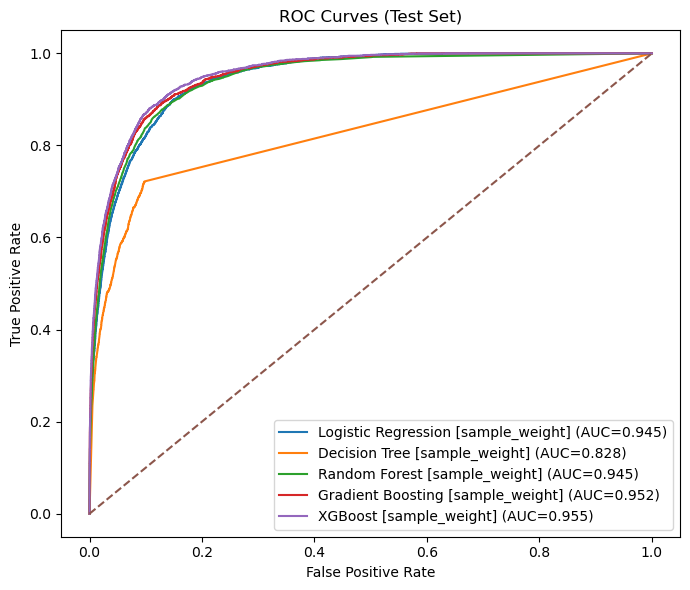

In [36]:
plt.figure(figsize=(7,6))

for r in results:
    if r["y_prob"] is None:
        continue
    fpr, tpr, _ = roc_curve(y_test, r["y_prob"])
    label = f'{r["name"]} (AUC={r["auc"]:.3f})' if r["auc"] is not None else r["name"]
    plt.plot(fpr, tpr, label=label)

plt.plot([0,1],[0,1],"--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (Test Set)")
plt.legend()
plt.tight_layout()
plt.show()


### 6.2 Confusion matrix heatmaps 

In [39]:
import numpy as np
import matplotlib.pyplot as plt

def plot_cm_better(cmw, title="", class_names=("<=50K", ">50K"), normalize="true", scale=None):
    """
    cmw: 2x2 confusion matrix (can be weighted floats)
    normalize:
      - None: raw values only
      - "true": row-normalized (recall view)
      - "pred": col-normalized (precision view)
      - "all": global-normalized
    scale: None or a number like 1e6 to display raw values in "millions"
    """
    cmw = np.asarray(cmw, dtype=float)

    # Optionally scale raw values for readability
    disp_cmw = cmw.copy()
    scale_suffix = ""
    if scale is not None and scale != 0:
        disp_cmw = disp_cmw / scale
        scale_suffix = f" (÷{scale:.0e})"

    # Build normalized matrix for coloring
    if normalize is None:
        cm_color = disp_cmw
        norm_label = "Raw"
    elif normalize == "true":
        row_sums = cmw.sum(axis=1, keepdims=True)
        cm_color = np.divide(cmw, row_sums, out=np.zeros_like(cmw), where=row_sums != 0)
        norm_label = "Row-normalized (by True)"
    elif normalize == "pred":
        col_sums = cmw.sum(axis=0, keepdims=True)
        cm_color = np.divide(cmw, col_sums, out=np.zeros_like(cmw), where=col_sums != 0)
        norm_label = "Col-normalized (by Pred)"
    elif normalize == "all":
        total = cmw.sum()
        cm_color = cmw / total if total != 0 else np.zeros_like(cmw)
        norm_label = "Global-normalized"
    else:
        raise ValueError("normalize must be None, 'true', 'pred', or 'all'")

    fig, ax = plt.subplots(figsize=(7, 6))

    # For normalized matrices, use fixed 0..1 range
    if normalize is None:
        im = ax.imshow(cm_color)
    else:
        im = ax.imshow(cm_color, vmin=0, vmax=1)

    ax.set_title(f"{title}\n{norm_label}{scale_suffix}")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")

    ax.set_xticks([0, 1], class_names)
    ax.set_yticks([0, 1], class_names)

    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label("Proportion" if normalize is not None else f"Value{scale_suffix}")

    # Annotate: percent (big) + raw value (small)
    for (i, j), _ in np.ndenumerate(cmw):
        if normalize is None:
            txt = f"{disp_cmw[i, j]:,.2f}"
        else:
            pct = cm_color[i, j] * 100
            txt = f"{pct:.1f}%\n({disp_cmw[i,j]:,.2f})"
        # auto-contrast text color
        color = "white" if (normalize is not None and cm_color[i, j] > 0.5) else "black"
        ax.text(j, i, txt, ha="center", va="center", color=color, fontsize=11)

    ax.grid(False)
    plt.tight_layout()
    plt.show()


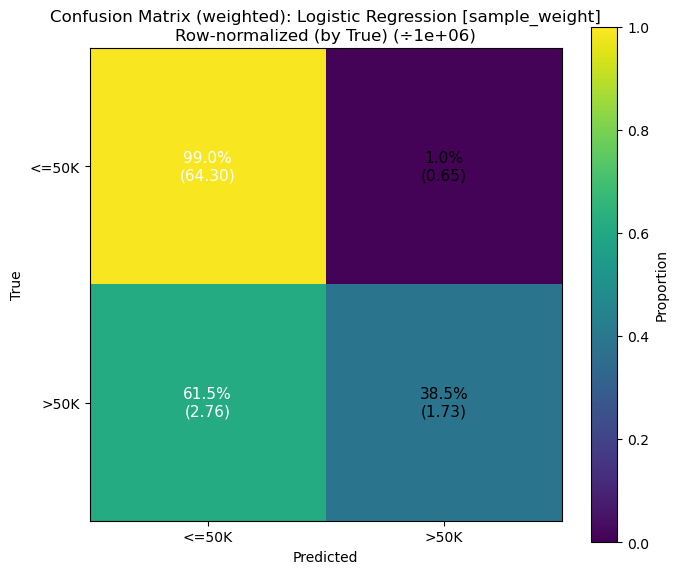

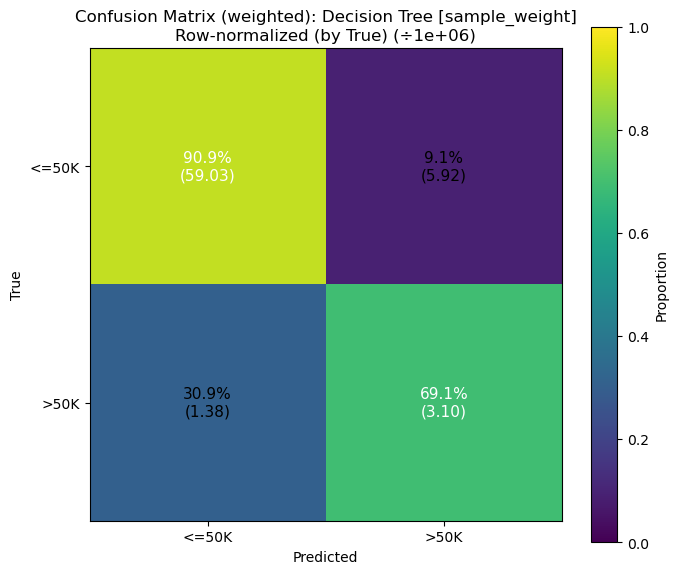

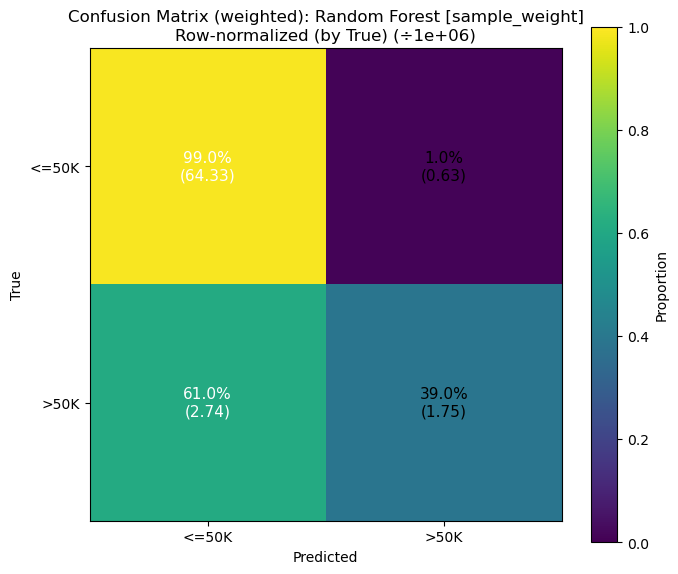

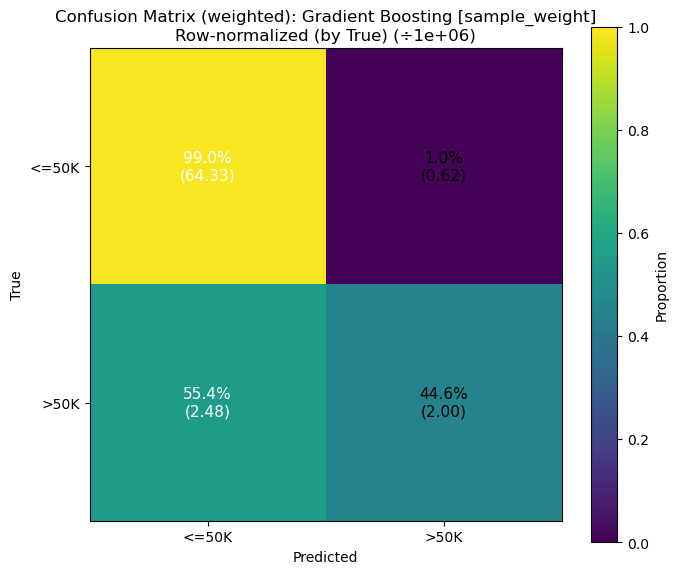

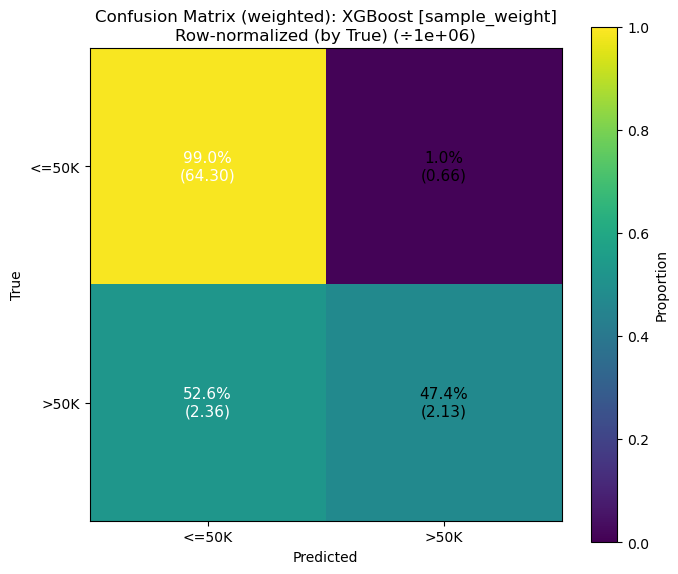

In [40]:
for r in results:
    if r.get("cm_w") is not None:
        plot_cm_better(
            r["cm_w"],
            title=f"Confusion Matrix (weighted): {r['name']}",
            normalize="true",   # best default
            scale=1e6           # show raw numbers in “millions”
        )


### 6.3 Threshold analysis

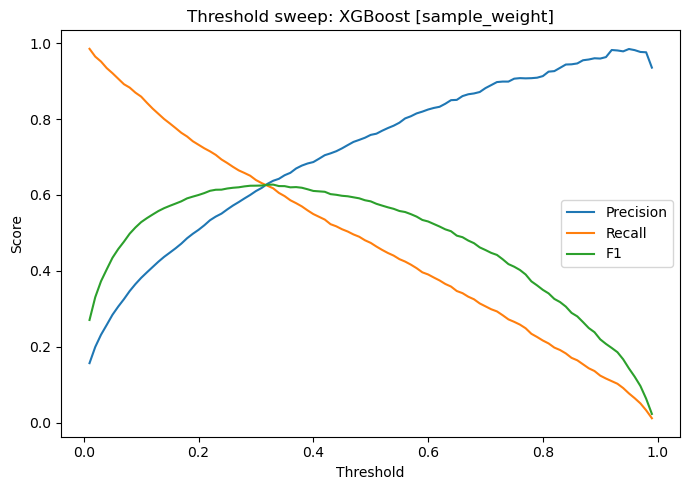

Best F1 threshold: 0.33 F1: 0.6272820512820513


In [42]:
if best.get("y_prob") is None:
    print("Best model has no probability output; skipping threshold analysis.")
else:
    y_prob = best["y_prob"]
    thresholds = np.linspace(0.01, 0.99, 99)

    precisions, recalls, f1s = [], [], []
    for t in thresholds:
        y_hat = (y_prob >= t).astype(int)
        precisions.append(precision_score(y_test, y_hat, zero_division=0))
        recalls.append(recall_score(y_test, y_hat, zero_division=0))
        f1s.append(f1_score(y_test, y_hat, zero_division=0))

    plt.figure(figsize=(7,5))
    plt.plot(thresholds, precisions, label="Precision")
    plt.plot(thresholds, recalls, label="Recall")
    plt.plot(thresholds, f1s, label="F1")
    plt.xlabel("Threshold")
    plt.ylabel("Score")
    plt.title(f"Threshold sweep: {best_name}")
    plt.legend()
    plt.tight_layout()
    plt.show()

    best_f1_idx = int(np.argmax(f1s))
    print("Best F1 threshold:", float(thresholds[best_f1_idx]), "F1:", float(f1s[best_f1_idx]))


## 7) Hyperparameter tuning (best model)

We tune the **best model family** using `RandomizedSearchCV`

In [46]:

t_star = float(thresholds[best_f1_idx])   

from sklearn.base import clone

tuned_res = None
base = clone(best_model)

best_label = best_name.split(" [")[0]

param_dist = None
if "Random Forest" in best_label:
    param_dist = {
        "clf__n_estimators": [300, 500, 800],
        "clf__max_depth": [None, 10, 20, 40],
        "clf__min_samples_split": [2, 5, 10],
        "clf__min_samples_leaf": [1, 2, 5],
        "clf__max_features": ["sqrt", "log2", None],
    }
elif "Gradient Boosting" in best_label:
    param_dist = {
        "clf__n_estimators": [200, 400, 700],
        "clf__learning_rate": [0.02, 0.05, 0.1],
        "clf__max_depth": [2, 3, 4],
    }
elif "Decision Tree" in best_label:
    param_dist = {
        "clf__max_depth": [None, 5, 10, 20, 40],
        "clf__min_samples_split": [2, 5, 10],
        "clf__min_samples_leaf": [1, 2, 5, 10],
    }
elif "Logistic Regression" in best_label:
    param_dist = {
        "clf__C": [0.1, 0.3, 1.0, 3.0, 10.0],
        "clf__penalty": ["l2"],
        "clf__solver": ["lbfgs", "saga"],
    }
elif "XGBoost" in best_label:
    param_dist = {
        "clf__n_estimators": [400, 700, 1000],
        "clf__max_depth": [3, 4, 5],
        "clf__learning_rate": [0.02, 0.05, 0.1],
        "clf__subsample": [0.7, 0.9, 1.0],
        "clf__colsample_bytree": [0.7, 0.9, 1.0],
    }

if param_dist is None:
    print("No tuning space defined for:", best_label)
else:
    search = RandomizedSearchCV(
        estimator=base,
        param_distributions=param_dist,
        n_iter=20,
        scoring="roc_auc",
        cv=5,
        random_state=RANDOM_STATE,
        n_jobs=-1,
        verbose=1
    )

    fit_kwargs = {}
    if best_scenario == "sample_weight" and w_train is not None:
        fit_kwargs = {"clf__sample_weight": w_train}

    search.fit(X_train, y_train, **fit_kwargs)
    print("Best params:", search.best_params_)
    print("Best CV score:", search.best_score_)

    tuned_model = search.best_estimator_
    tuned_res = evaluate_model(
        f"Tuned {best_label} @t={t_star:.2f}",
        tuned_model,
        X_test,
        y_test,
        sample_weight= w_test,
        threshold=t_star  
    )


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best params: {'clf__subsample': 0.7, 'clf__n_estimators': 1000, 'clf__max_depth': 5, 'clf__learning_rate': 0.02, 'clf__colsample_bytree': 0.7}
Best CV score: 0.9525732163267151
=== Tuned XGBoost @t=0.33 ===
Threshold used: 0.330
Accuracy: 0.9543666207242201
Precision: 0.6361746361746362
Recall   : 0.6179321486268174
F1       : 0.6269207129686539
ROC-AUC  : 0.9554001996067859

Weighted Accuracy : 0.9533573825853673
Weighted Precision: 0.644665656582039
Weighted Recall   : 0.6186075667962742
Weighted F1       : 0.6313678558765909
Weighted ROC-AUC  : 0.9556044514550639

Classification report (unweighted):
              precision    recall  f1-score   support

           0       0.97      0.98      0.98     37429
           1       0.64      0.62      0.63      2476

    accuracy                           0.95     39905
   macro avg       0.81      0.80      0.80     39905
weighted avg       0.95      0.95      0.95     39905

C